Diễn giải lựa chọn giải pháp
1. Lựa chọn mô hình

Em chọn mô hình InceptionV3 vì đây là một mạng CNN sâu, đã được huấn luyện trên ImageNet, giúp trích xuất tốt các đặc trưng như khuôn mặt hay tóc – yếu tố quan trọng để phân biệt giới tính. Với chuyển tiếp học (fine-tune 30 lớp cuối), mô hình phù hợp với GPU trên Kaggle và tiết kiệm thời gian huấn luyện. Em kết hợp GlobalAveragePooling2D, Dropout (0.6, 0.5) và regularization L2 để giảm độ phức tạp và tránh overfitting. Kết quả độ chính xác 0.96 trên tập validation cho thấy hiệu quả rõ rệt.

2. Xử lý dữ liệu

Dữ liệu có 4000 ảnh mỗi lớp (Male, Female) trong Train, 500 trong Validation. Em resize ảnh về 299x299, chuẩn hóa bằng rescale=1./255. Để tăng đa dạng, em dùng ImageDataGenerator với xoay, dịch chuyển, lật ngang và thay đổi độ sáng. Dù dữ liệu cân bằng, em vẫn tính class_weight để đảm bảo công bằng, dù kết quả cho thấy trọng số gần bằng nhau.

3. Siêu tham số

Batch size: Em chọn 64 sau khi thử 125 bị lỗi OOM, phù hợp với GPU 16GB VRAM.
Optimizer: Em dùng AdamW với learning_rate=0.0001 và weight_decay=0.0002 để tối ưu và tránh overfitting.
Callbacks: Em áp dụng ReduceLROnPlateau giảm learning rate sau 3 epoch, ModelCheckpoint lưu mô hình tốt nhất, EarlyStopping dừng sau 7 epoch nếu không cải thiện. Kết quả hội tụ tốt với accuracy 0.96.
4. Đánh giá

Độ chính xác: Đạt 0.96 trên cả mô hình cuối và tốt nhất.
Confusion Matrix: Hầu hết dự đoán đúng (khoảng 480/500 mỗi lớp), ít nhầm lẫn.
Classification Report: Precision, recall, f1-score đều 0.96, cho thấy mô hình ổn định.
Thời gian: 277ms/step với 32 bước/epoch, tận dụng tốt GPU.

In [9]:
!pip uninstall tensorflow -y
!pip install tensorflow numpy pandas matplotlib seaborn pillow scikit-learn -q

Found existing installation: tensorflow 2.19.0
Uninstalling tensorflow-2.19.0:
  Successfully uninstalled tensorflow-2.19.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-decision-forests 1.11.0 requires tensorflow==2.18.0, but you have tensorflow 2.19.0 which is incompatible.
dopamine-rl 4.1.2 requires gymnasium>=1.0.0, but you have gymnasium 0.29.0 which is incompatible.
tf-keras 2.18.0 requires tensorflow<2.19,>=2.18, but you have tensorflow 2.19.0 which is incompatible.
tensorflow-text 2.18.1 requires tensorflow<2.19,>=2.18.0, but you have tensorflow 2.19.0 which is incompatible.


In [10]:
import tensorflow as tf
from tensorflow.keras.applications import InceptionV3 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from tensorflow.keras.regularizers import l2
from PIL import Image
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, classification_report

In [11]:
# Kiểm tra GPU
print("GPU Available:", tf.config.list_physical_devices('GPU'))
print("TensorFlow Version:", tf.__version__)

# Thiết lập các tham số cơ bản
img_height, img_width = 299, 299
batch_size = 64

# Đường dẫn đến các thư mục dữ liệu trên Kaggle
base_dir = '/kaggle/input/2425-ii-ait-3002-1-gender-classification/Dataset'
train_dir = os.path.join(base_dir, 'Train')
val_dir = os.path.join(base_dir, 'Val')
test_dir = os.path.join(base_dir, 'Test')

# Kiểm tra sự tồn tại của các thư mục
for directory in [train_dir, val_dir, test_dir]:
    if not os.path.exists(directory):
        print(f"Không tìm thấy thư mục: {directory}")
        raise FileNotFoundError(f"Thư mục {directory} không tồn tại.")
    else:
        print(f"Thư mục được tìm thấy: {directory}")

# Thống kê số lượng ảnh trong từng thư mục
def count_images(directory, classes=['Male', 'Female']):
    counts = {}
    for cls in classes:
        cls_dir = os.path.join(directory, cls)
        counts[cls] = len(os.listdir(cls_dir)) if os.path.exists(cls_dir) else 0
    return counts

train_counts = count_images(train_dir)
val_counts = count_images(val_dir)
test_counts = count_images(test_dir)

print("\nSố lượng ảnh trong tập Train:", train_counts)
print("Số lượng ảnh trong tập Validation:", val_counts)
print("Số lượng ảnh trong tập Test:", test_counts)

GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
TensorFlow Version: 2.19.0
Thư mục được tìm thấy: /kaggle/input/2425-ii-ait-3002-1-gender-classification/Dataset/Train
Thư mục được tìm thấy: /kaggle/input/2425-ii-ait-3002-1-gender-classification/Dataset/Val
Thư mục được tìm thấy: /kaggle/input/2425-ii-ait-3002-1-gender-classification/Dataset/Test

Số lượng ảnh trong tập Train: {'Male': 4000, 'Female': 4000}
Số lượng ảnh trong tập Validation: {'Male': 500, 'Female': 500}
Số lượng ảnh trong tập Test: {'Male': 0, 'Female': 0}


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


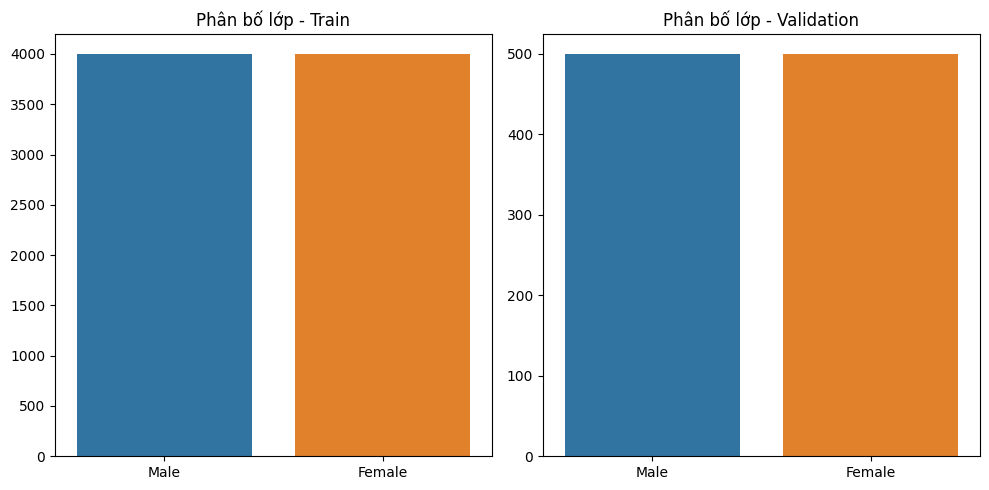

In [12]:
# Vẽ biểu đồ phân bố lớp
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
sns.barplot(x=list(train_counts.keys()), y=list(train_counts.values()))
plt.title('Phân bố lớp - Train')
plt.subplot(1, 2, 2)
sns.barplot(x=list(val_counts.keys()), y=list(val_counts.values()))
plt.title('Phân bố lớp - Validation')
plt.tight_layout()
plt.show()

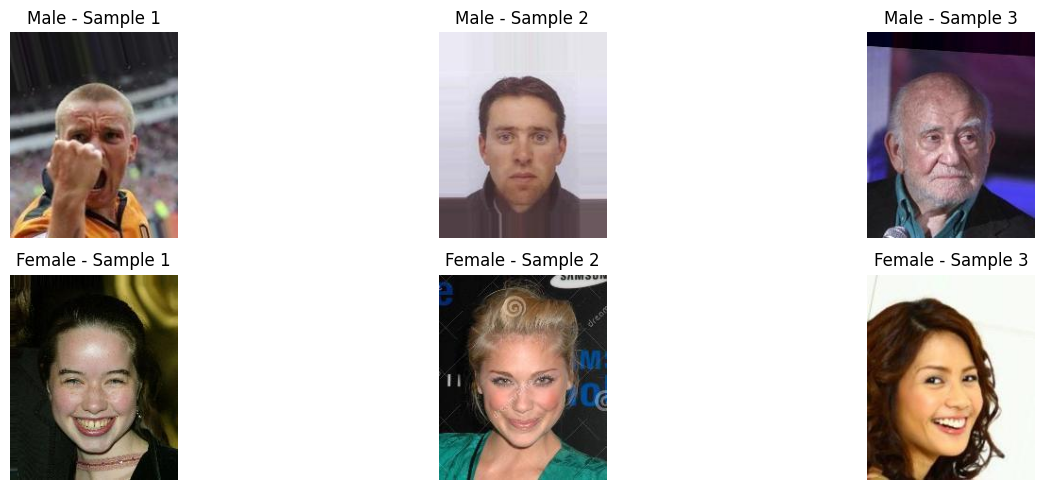

In [13]:
# Hiển thị một vài mẫu ảnh từ tập Train
def display_sample_images(directory, classes=['Male', 'Female'], num_samples=3):
    plt.figure(figsize=(15, 5))
    for i, cls in enumerate(classes):
        cls_dir = os.path.join(directory, cls)
        if not os.path.exists(cls_dir):
            continue
        images = os.listdir(cls_dir)[:num_samples]
        for j, img_name in enumerate(images):
            img_path = os.path.join(cls_dir, img_name)
            img = Image.open(img_path)
            plt.subplot(len(classes), num_samples, i * num_samples + j + 1)
            plt.imshow(img)
            plt.title(f"{cls} - Sample {j+1}")
            plt.axis('off')
    plt.tight_layout()
    plt.show()

display_sample_images(train_dir)

In [14]:
# Tạo ImageDataGenerator với tăng cường dữ liệu mạnh hơn
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    fill_mode='nearest',
    brightness_range=[0.7, 1.3]  
)

# Chỉ rescale cho tập validation
val_datagen = ImageDataGenerator(rescale=1./255)

# Tải dữ liệu từ các thư mục
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary'
)

validation_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)

# In ánh xạ nhãn
print("Class indices:", train_generator.class_indices)

# Tính toán class weights để xử lý mất cân bằng lớp
classes = np.unique(train_generator.classes)
class_weights = compute_class_weight('balanced', classes=classes, y=train_generator.classes)
class_weight_dict = dict(zip(classes, class_weights))
print("Class weights:", class_weight_dict)

# Tải mô hình InceptionV3 với trọng số pre-trained
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

# Fine-tune các lớp cuối
for layer in base_model.layers[:-30]:  # Đóng băng tất cả trừ 30 lớp cuối
    layer.trainable = False
for layer in base_model.layers[-30:]:
    layer.trainable = True

# Xây dựng mô hình mới với GlobalAveragePooling2D và giảm độ phức tạp
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),  
    Dropout(0.6),  
    Dense(128, activation='relu', kernel_regularizer=l2(0.01)), 
    BatchNormalization(),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Biên dịch mô hình với optimizer AdamW và weight decay
model.compile(optimizer=AdamW(learning_rate=0.0001, weight_decay=0.0002),  
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

# Định nghĩa callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.00001, min_delta=0.001)
checkpoint = ModelCheckpoint('/kaggle/working/best_model_improved.h5',
                             monitor='val_accuracy',
                             save_best_only=True,
                             mode='max',
                             verbose=1)
early_stopping = EarlyStopping(monitor='val_accuracy',
                               patience=7,
                               mode='max',
                               verbose=1)

# Huấn luyện mô hình
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=50,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    callbacks=[reduce_lr, checkpoint, early_stopping],
    class_weight=class_weight_dict
)

Found 8000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Class indices: {'Female': 0, 'Male': 1}
Class weights: {0: 1.0, 1: 1.0}


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ inception_v3 (Functional)            │ (None, 8, 8, 2048)          │      21,802,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_189              │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 22,065,697 (84.17 MB)

 Trainable params: 5,418,689 (20.67 MB)

 Non-trainable params: 16,647,008 (63.50 MB)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7837 - loss: 2.8704
Epoch 1: val_accuracy improved from -inf to 0.91875, saving model to /kaggle/working/best_model_improved.h5
125/125 ━━━━━━━━━━━━━━━━━━━━ 220s 2s/step - accuracy: 0.7842 - loss: 2.8688 - val_accuracy: 0.9187 - val_loss: 2.3216 - learning_rate: 1.0000e-04
Epoch 2/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8995 - loss: 2.3275
Epoch 2: val_accuracy improved from 0.91875 to 0.92813, saving model to /kaggle/working/best_model_improved.h5
125/125 ━━━━━━━━━━━━━━━━━━━━ 184s 1s/step - accuracy: 0.8995 - loss: 2.3271 - val_accuracy: 0.9281 - val_loss: 2.0361 - learning_rate: 1.0000e-04
Epoch 3/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9035 - loss: 2.0563
Epoch 3: val_accuracy improved from 0.92813 to 0.93229, saving model to /kaggle/working/best_model_improved.h5
125/125 ━━━━━━━━━━━━━━━━━━━━ 187s 1s/step - accuracy: 0.9035 - loss: 2.0558 - val_accuracy: 0.9323 - val_loss: 1.8042 - lea

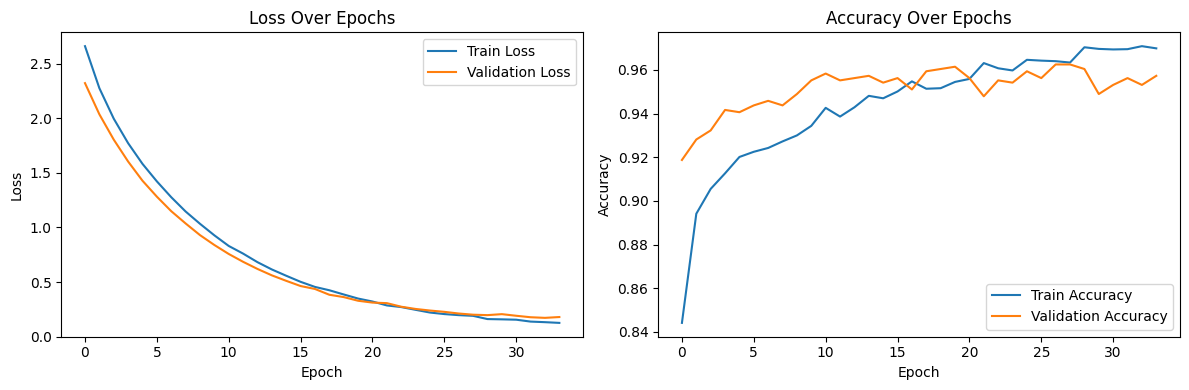

In [15]:
# Vẽ biểu đồ loss và accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

16/16 ━━━━━━━━━━━━━━━━━━━━ 7s 460ms/step - accuracy: 0.9494 - loss: 0.2108
Độ chính xác trên tập validation (mô hình cuối cùng): 0.9580000042915344
16/16 ━━━━━━━━━━━━━━━━━━━━ 15s 451ms/step - accuracy: 0.9612 - loss: 0.2178
Độ chính xác trên tập validation (mô hình tốt nhất): 0.9620000123977661
16/16 ━━━━━━━━━━━━━━━━━━━━ 17s 605ms/step
Class labels: ['Female', 'Male']
Confusion Matrix:
[[481  19]
 [ 19 481]]


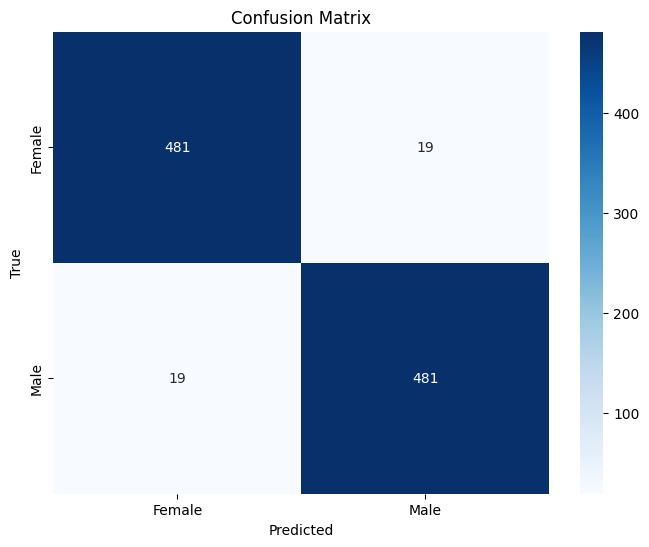

Classification Report:
              precision    recall  f1-score   support

      Female       0.96      0.96      0.96       500
        Male       0.96      0.96      0.96       500

    accuracy                           0.96      1000
   macro avg       0.96      0.96      0.96      1000
weighted avg       0.96      0.96      0.96      1000

32/32 ━━━━━━━━━━━━━━━━━━━━ 15s 277ms/step
File submission_improved.csv đã được tạo.


In [16]:
# Đánh giá mô hình trên tập validation (mô hình cuối cùng)
validation_generator.reset()  # Reset generator để đảm bảo đồng bộ
val_loss, val_accuracy = model.evaluate(validation_generator)
print(f'Độ chính xác trên tập validation (mô hình cuối cùng): {val_accuracy}')

# Tải mô hình tốt nhất
best_model = tf.keras.models.load_model('/kaggle/working/best_model_improved.h5')

# Đánh giá mô hình tốt nhất trên tập validation
best_val_loss, best_val_accuracy = best_model.evaluate(validation_generator)
print(f'Độ chính xác trên tập validation (mô hình tốt nhất): {best_val_accuracy}')

# Tính toán Confusion Matrix và Classification Report
true_labels = validation_generator.classes
predictions = best_model.predict(validation_generator, steps=validation_generator.samples // batch_size + 1)
predicted_classes = (predictions > 0.5).astype(int).flatten()

class_labels = list(train_generator.class_indices.keys())
print("Class labels:", class_labels)

cm = confusion_matrix(true_labels, predicted_classes)
print("Confusion Matrix:")
print(cm)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

print("Classification Report:")
print(classification_report(true_labels, predicted_classes, target_names=class_labels))

# Tải và tiền xử lý dữ liệu test
test_images = sorted([os.path.join(test_dir, fname) for fname in os.listdir(test_dir) if fname.endswith('.jpg')])

def load_and_preprocess_image(path):
    img = Image.open(path)
    img = img.resize((img_width, img_height))
    img = np.array(img) / 255.0
    return img

test_data = np.array([load_and_preprocess_image(path) for path in test_images])

# Dự đoán trên tập test
predictions = best_model.predict(test_data)
predicted_classes = (predictions > 0.5).astype(int).flatten()
submission_labels = 1 - predicted_classes  

# Tạo file submission
ids = [os.path.splitext(os.path.basename(path))[0] for path in test_images]
submission = pd.DataFrame({
    'ID': ids,
    'Label': submission_labels
})
submission.to_csv('/kaggle/working/submission_improved.csv', index=False)
print("File submission_improved.csv đã được tạo.")